In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchaudio
import torchaudio.transforms as transforms

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import numpy as np

# Датасет

In [4]:
class AudioSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None, spectrogram_size=(128, 256)):
        self.root_dir = root_dir
        self.transform = transform
        self.spectrogram_size = spectrogram_size

        self.audio_files = []
        self.labels = []

        self.emotion_map = {
            'angry': 0,
            'sad': 1,
            'happy': 2,
            'surprise': 3,
            'disgust': 4,
            'fear': 5,
            'neutral': 6
        }

        for emotion in self.emotion_map.keys():
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.isdir(emotion_dir):
                for file_name in os.listdir(emotion_dir):
                    if file_name.endswith('.wav'):
                        self.audio_files.append(os.path.join(emotion_dir, file_name))
                        self.labels.append(self.emotion_map[emotion])

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_file = self.audio_files[idx]
        waveform, sample_rate = torchaudio.load(audio_file)

        # Convert to mono if stereo
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Create spectrogram
        spectrogram_transform = transforms.MelSpectrogram(n_fft=1024, hop_length=512)
        spectrogram = spectrogram_transform(waveform)

        # Resize the spectrogram to the desired size
        spectrogram = self._resize_spectrogram(spectrogram)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        # # Ensure spectrogram has 4D shape: (batch_size, channels, height, width)
        # if spectrogram.ndimension() == 3:
        #     spectrogram = spectrogram.unsqueeze(0)  # Add channel dimension if necessary

        label = self.labels[idx]
        sample = {'spectrogram': spectrogram, 'label': label}

        return sample

    def _resize_spectrogram(self, spectrogram):
        """
        Resize the spectrogram to the desired size by padding or trimming.
        """
        # Convert spectrogram to numpy array
        spec_np = spectrogram.numpy()

        # Get current size
        c, h, w = spec_np.shape

        # Calculate padding
        pad_h = max(0, self.spectrogram_size[0] - h)
        pad_w = max(0, self.spectrogram_size[1] - w)
        trim_h = max(0, h - self.spectrogram_size[0])
        trim_w = max(0, w - self.spectrogram_size[1])

        # Trim the spectrogram if needed
        if trim_h > 0 or trim_w > 0:
            spec_np = spec_np[:, :self.spectrogram_size[0], :self.spectrogram_size[1]]

        # Pad the spectrogram if needed
        if pad_h > 0 or pad_w > 0:
            spec_np = np.pad(spec_np, ((0, 0), (0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

        return torch.tensor(spec_np, dtype=torch.float32)

In [5]:
root_dir = '/content/drive/MyDrive/astm/audios'
dataset = AudioSpectrogramDataset(root_dir=root_dir, spectrogram_size=(128, 256))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Модель

In [6]:
class EmotionRecognitionModel(nn.Module):
    def __init__(self):
        super(EmotionRecognitionModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(p=0.5)

        # self.fc1 = nn.Linear(64 * 32 * 64, 128)
        self.fc1 = nn.Linear(64 * 16 * 32, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, self.num_flat_features(x))

        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = EmotionRecognitionModel()


# Обучение

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

num_epochs = 20
patience = 10
patience_counter = 0

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


In [7]:
def train_model(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_loader:
            spectrograms = batch['spectrogram']
            labels = batch['label']

            # Move data to device
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(spectrograms)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Evaluate on test data
        test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [12]:
def evaluate_model(loader, model, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            spectrograms = batch['spectrogram']
            labels = batch['label']

            # Move data to device
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            # Forward pass
            outputs = model(spectrograms)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {100 * correct / total:.4f}%')

    return avg_loss, accuracy

In [13]:
train_losses, test_losses, train_accuracies, test_accuracies = train_model(train_loader, model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/20, Loss: 0.7923
Epoch 2/20, Loss: 0.3623
Epoch 3/20, Loss: 0.1411
Epoch 4/20, Loss: 0.1064
Epoch 5/20, Loss: 0.1799
Epoch 6/20, Loss: 0.1681
Epoch 7/20, Loss: 0.0724
Epoch 8/20, Loss: 0.1420
Epoch 9/20, Loss: 0.1959
Epoch 10/20, Loss: 0.1038
Epoch 11/20, Loss: 0.1410
Epoch 12/20, Loss: 0.0525
Epoch 13/20, Loss: 0.2802
Epoch 14/20, Loss: 0.0431
Epoch 15/20, Loss: 0.1314
Epoch 16/20, Loss: 0.0928
Epoch 17/20, Loss: 0.0613
Epoch 18/20, Loss: 0.1539
Epoch 19/20, Loss: 0.0329
Epoch 20/20, Loss: 0.4796


In [14]:
avg_loss, accuracy = evaluate_model(test_loader, model)

Accuracy: 99.64%


In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

def evaluate_model(test_loader, model, criterion):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            spectrograms = batch['spectrogram']
            labels = batch['label']

            spectrograms, labels = spectrograms.to(device), labels.to(device)

            outputs = model(spectrograms)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct_predictions / total_predictions

    return test_loss, test_accuracy

def train_model(train_loader, test_loader, model, criterion, optimizer, num_epochs=10, patience=3):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        model.train()

        for batch in train_loader:
            spectrograms = batch['spectrogram']
            labels = batch['label']

            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(spectrograms)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Evaluate on test data
        test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

        # Check for early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            early_stop_counter = 0
            # Save the model with the best performance
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, test_losses, train_accuracies, test_accuracies

# Hyperparameters
num_epochs = 10
patience = 3
learning_rate = 0.001

# Define model, criterion, optimizer
model = EmotionRecognitionModel().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies = train_model(train_loader, test_loader, model, criterion, optimizer, num_epochs=num_epochs, patience=patience)

Epoch [1/10], Loss: 0.8184, Accuracy: 0.8469
Test Loss: 0.1880, Test Accuracy: 0.9429
Epoch [2/10], Loss: 0.4145, Accuracy: 0.9290
Test Loss: 0.1024, Test Accuracy: 0.9786
Epoch [3/10], Loss: 0.1344, Accuracy: 0.9799
Test Loss: 0.0915, Test Accuracy: 0.9732
Epoch [4/10], Loss: 0.1666, Accuracy: 0.9688
Test Loss: 0.1226, Test Accuracy: 0.9589
Epoch [5/10], Loss: 0.0683, Accuracy: 0.9830
Test Loss: 0.0174, Test Accuracy: 0.9946
Epoch [6/10], Loss: 0.0745, Accuracy: 0.9848
Test Loss: 0.0681, Test Accuracy: 0.9964
Epoch [7/10], Loss: 0.1592, Accuracy: 0.9808
Test Loss: 0.0839, Test Accuracy: 0.9804
Epoch [8/10], Loss: 0.1832, Accuracy: 0.9746
Test Loss: 0.1147, Test Accuracy: 0.9821
Early stopping triggered


# Графики

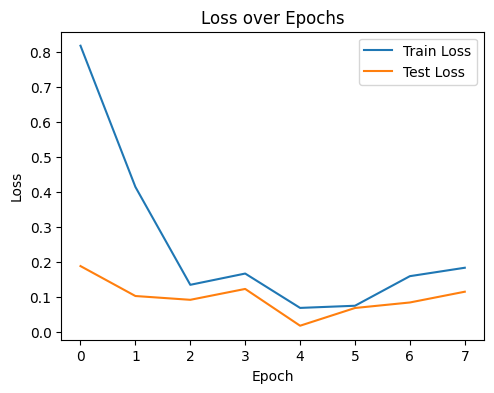

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

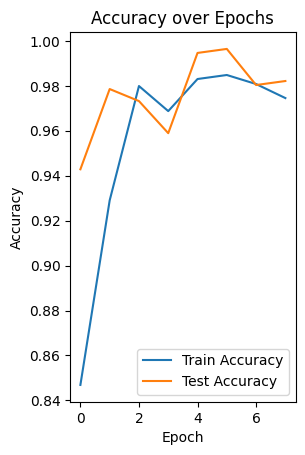

In [14]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Сохранение

In [15]:
model_path = "emotion_recognition_model.pth"
torch.save(model.state_dict(), model_path)